In [13]:
# Cell 1: Imports and Paths
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Base folder containing the three model subfolders
BASE_DIR = "."  # ← change this to your root data folder
MODEL_DIRS = ["AStar", "MLAg", "Tremaux"]

# Maze sizes of interest
MAZE_SIZES = ["5x5", "8x8", "10x10"]


In [14]:
# Cell 2: Helper to load a single CSV folder (5 runs)
def load_folder(folder_path):
    runs = []
    for csv_file in glob.glob(os.path.join(folder_path, "*.csv")):
        with open(csv_file, "r") as f:
            header = [next(f) for _ in range(6)]
            # Skip files marked DNF
            if header[0].startswith("FinalResult,DNF"):
                continue
            df = pd.read_csv(f, names=header[5].strip().split(","), skiprows=6)
        # drop duplicate FrameTime rows
        df = df.drop_duplicates(subset=["FrameTime"])
        # drop low-FPS rows
        df = df[df["FPS"] >= 50]
        df = df.reset_index(drop=True)
        runs.append(df)
    return runs


In [15]:
# Cell 3: Load all data into a nested dict
# Structure: data[model][maze_size] = list of DataFrames
data = {m: {s: [] for s in MAZE_SIZES} for m in MODEL_DIRS}

for model in MODEL_DIRS:
    for maze_size in MAZE_SIZES:
        # find all seed folders matching the maze size
        pattern = os.path.join(BASE_DIR, model, f"{maze_size}*")
        for folder in glob.glob(pattern):
            data[model][maze_size].extend(load_folder(folder))


In [16]:
# Cell 4: Compute final steps per run
steps_summary = []
for model in MODEL_DIRS:
    for size in MAZE_SIZES:
        runs = data[model][size]
        final_steps = [run["Steps"].iloc[-1] for run in runs if len(run)]
        for step in final_steps:
            steps_summary.append({"Model": model, "Size": size, "FinalSteps": step})
steps_df = pd.DataFrame(steps_summary)


Average Steps and Standard Deviation by Model and Maze Size:
  Model  Size       mean       std
  AStar 10x10  20.533333  3.583029
  AStar   5x5  11.733333  2.250926
  AStar   8x8  16.133333  3.419830
   MLAg 10x10  34.000000 24.610817
   MLAg   5x5  12.600000  4.299871
   MLAg   8x8  33.312500 22.893139
Tremaux 10x10 106.866667 43.962430
Tremaux   5x5  21.266667  7.045431
Tremaux   8x8  56.200000 23.213912


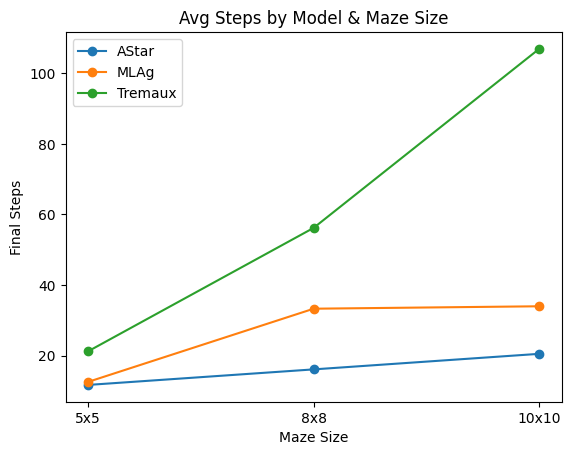

In [17]:
# Cell 5: Updated Average Steps & StdDev by Model & Maze Size
# Compute stats
agg = steps_df.groupby(["Model","Size"])['FinalSteps'].agg(['mean','std']).reset_index()
# Print out the values
print("Average Steps and Standard Deviation by Model and Maze Size:")
print(agg.to_string(index=False))

# Ensure sizes are in ascending order
size_order = ['5x5','8x8','10x10']
agg['Size'] = pd.Categorical(agg['Size'], categories=size_order, ordered=True)
agg = agg.sort_values(['Model','Size'])

# Plot points with error bars
fig, ax = plt.subplots()
for model in MODEL_DIRS:
    subset = agg[agg['Model']==model]
    ax.errorbar(subset['Size'], subset['mean'],
                marker='o', linestyle='-', label=model)
ax.set_xlabel('Maze Size')
ax.set_ylabel('Final Steps')
ax.set_title('Avg Steps by Model & Maze Size')
ax.legend()
plt.show()

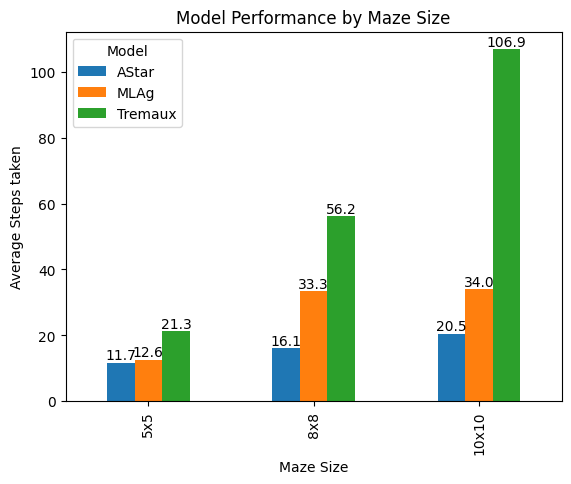

In [18]:
# Cell 6: Side-by-Side Bar Chart of Model Performance at Each Maze Size
# Pivot for bar chart
df_bar = agg.pivot(index='Size', columns='Model', values='mean')

fig, ax = plt.subplots()
df_bar.plot(kind='bar', ax=ax)
# Annotate bar values with 2 decimal places
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f')

ax.set_xlabel('Maze Size')
ax.set_ylabel('Average Steps taken')
ax.set_title('Model Performance by Maze Size')
ax.legend(title='Model')
plt.show()


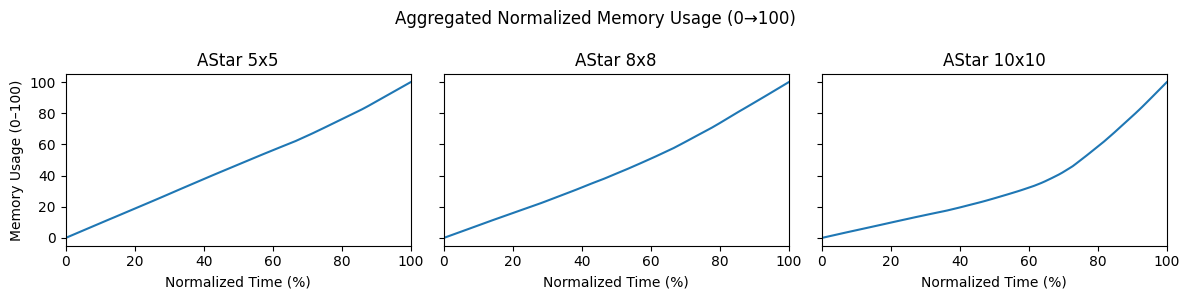

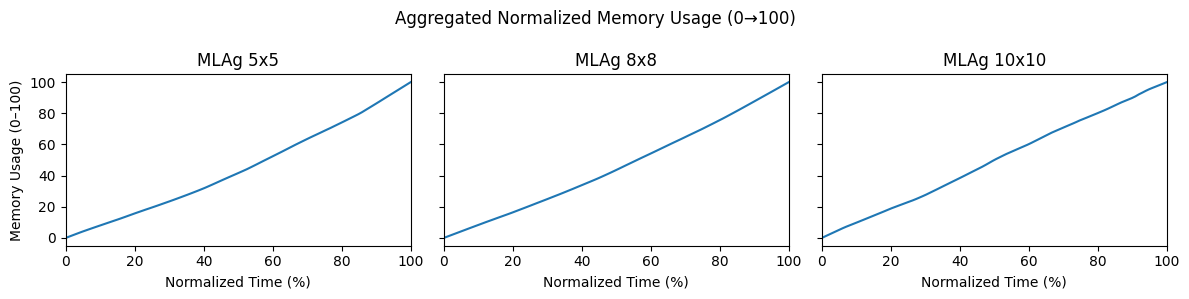

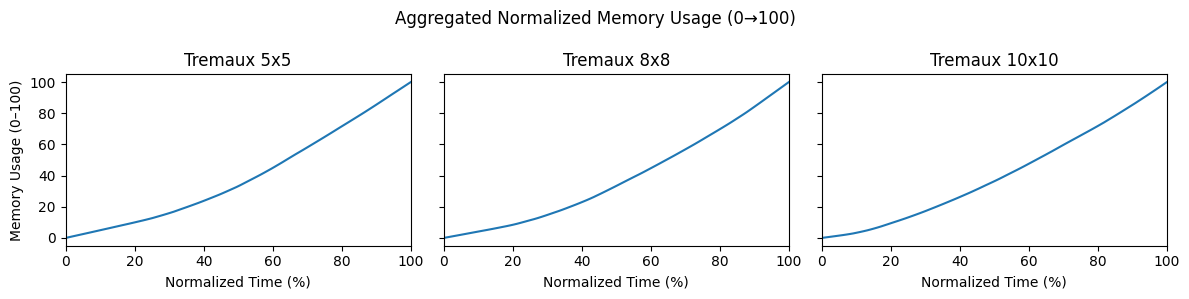

In [19]:
# Cell 7: Aggregated Normalized Memory Usage Over Time (0–100)
norm_x = np.linspace(0, 1, 100)
for model in MODEL_DIRS:
    fig, axes = plt.subplots(1, len(MAZE_SIZES), figsize=(12,3), sharey=True)
    for ax, size in zip(axes, MAZE_SIZES):
        all_interp = []
        for run in data[model][size]:
            mem = run['MemoryUsage'].astype(float).values
            # skip if no variation
            if mem.size < 2 or mem[-1] == mem[0]:
                continue
            t = np.linspace(0, 1, len(mem))
            norm_mem = (mem - mem[0]) / (mem[-1] - mem[0]) * 100
            interp = np.interp(norm_x, t, norm_mem)
            all_interp.append(interp)
        if not all_interp:
            continue
        mean_norm = np.mean(all_interp, axis=0)
        ax.plot(norm_x * 100, mean_norm)
        ax.set_xlim(0, 100)
        ax.set_title(f"{model} {size}")
        ax.set_xlabel("Normalized Time (%)")
    axes[0].set_ylabel("Memory Usage (0–100)")
    fig.suptitle("Aggregated Normalized Memory Usage (0→100)")
    plt.tight_layout()
    plt.show()


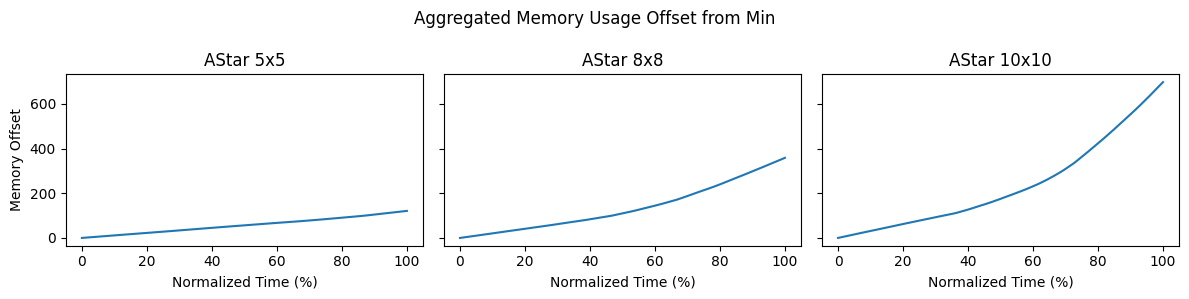

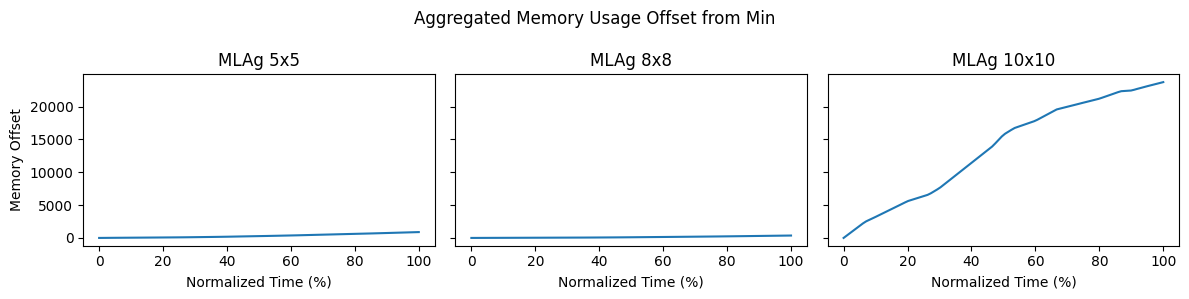

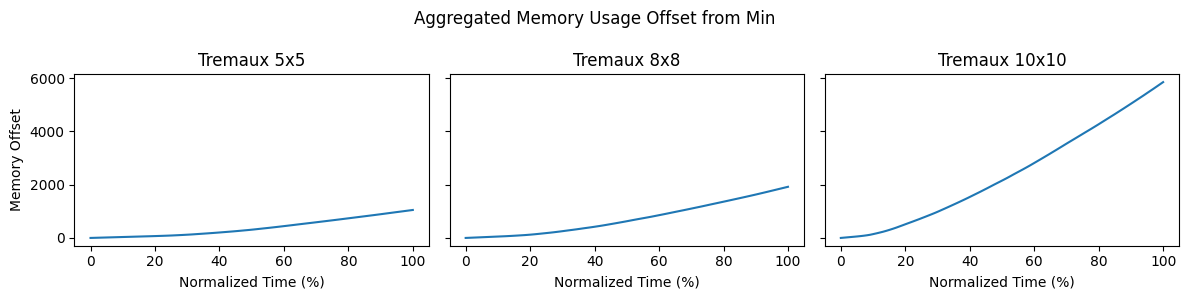

In [20]:
# Cell 8: Aggregated Memory Usage Offset from Min Over Time
for model in MODEL_DIRS:
    fig, axes = plt.subplots(1, len(MAZE_SIZES), figsize=(12,3), sharey=True)
    for ax, size in zip(axes, MAZE_SIZES):
        # align all runs to 100-point timeline
        norm_x = np.linspace(0, 1, 100)
        all_interp = []
        for run in data[model][size]:
            mem = run['MemoryUsage'].astype(float).values
            t = np.linspace(0, 1, len(mem))
            offset = mem - mem.min()
            interp = np.interp(norm_x, t, offset)
            all_interp.append(interp)
        mean_offset = np.mean(all_interp, axis=0)
        ax.plot(norm_x * 100, mean_offset)
        ax.set_title(f"{model} {size}")
        ax.set_xlabel("Normalized Time (%)")
    axes[0].set_ylabel("Memory Offset")
    fig.suptitle("Aggregated Memory Usage Offset from Min")
    plt.tight_layout()
    plt.show()


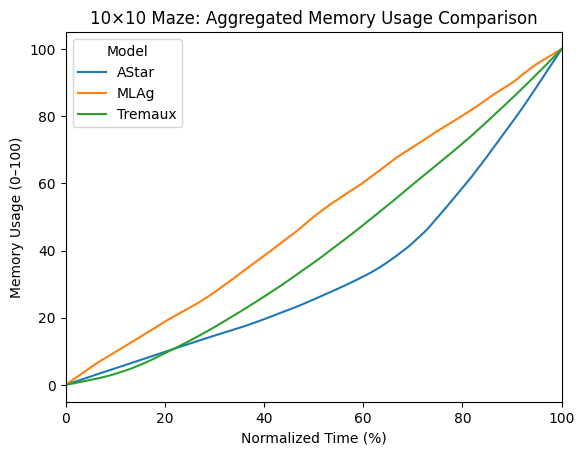

In [21]:
# Cell 9: 10x10 Comparison (Aggregated & Normalized) Across Models
fig, ax = plt.subplots()
norm_x = np.linspace(0, 1, 100)
for model in MODEL_DIRS:
    all_interp = []
    for run in data[model]["10x10"]:
        mem = run['MemoryUsage'].astype(float).values
        if mem.size < 2 or mem[-1] == mem[0]:
            continue
        t = np.linspace(0, 1, len(mem))
        norm_mem = (mem - mem[0]) / (mem[-1] - mem[0]) * 100
        interp = np.interp(norm_x, t, norm_mem)
        all_interp.append(interp)
    if not all_interp:
        continue
    mean_norm = np.mean(all_interp, axis=0)
    ax.plot(norm_x * 100, mean_norm, label=model)
ax.set_xlim(0, 100)
ax.set_xlabel("Normalized Time (%)")
ax.set_ylabel("Memory Usage (0–100)")
ax.set_title("10×10 Maze: Aggregated Memory Usage Comparison")
ax.legend(title='Model')
plt.show()


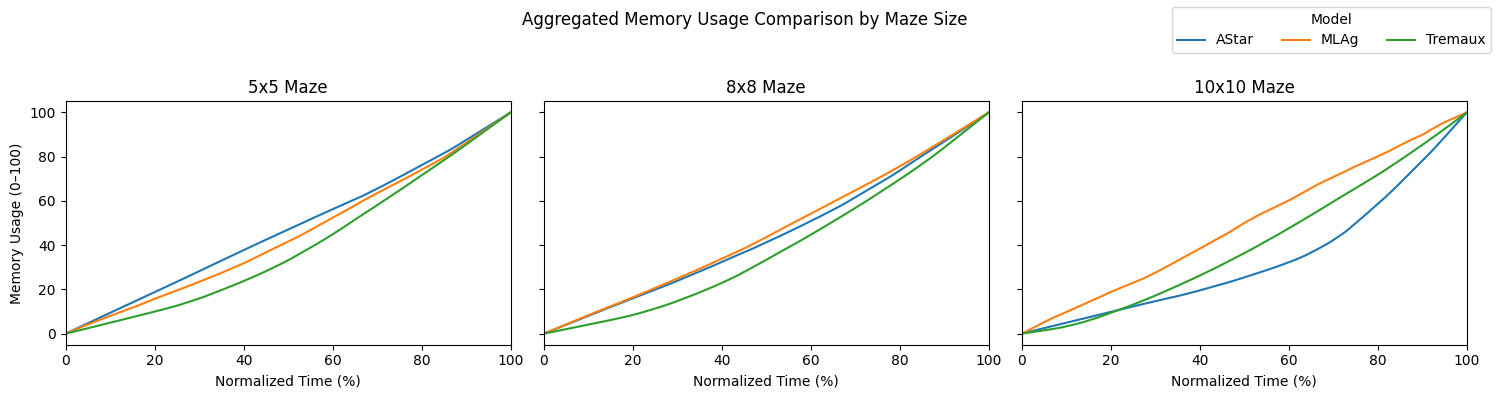

In [22]:
# Cell 10: Aggregated & Normalized Comparison Across Models by Maze Size
fig, axes = plt.subplots(1, len(MAZE_SIZES), figsize=(15,4), sharey=True)
for ax, size in zip(axes, MAZE_SIZES):
    for model in MODEL_DIRS:
        all_interp = []
        for run in data[model][size]:
            mem = run['MemoryUsage'].astype(float).values
            if mem.size < 2 or mem[-1] == mem[0]:
                continue
            t = np.linspace(0, 1, len(mem))
            norm_mem = (mem - mem[0]) / (mem[-1] - mem[0]) * 100
            interp = np.interp(norm_x, t, norm_mem)
            all_interp.append(interp)
        if not all_interp:
            continue
        mean_norm = np.mean(all_interp, axis=0)
        ax.plot(norm_x * 100, mean_norm, label=model)
    ax.set_xlim(0, 100)
    ax.set_xlabel("Normalized Time (%)")
    ax.set_title(f"{size} Maze")
axes[0].set_ylabel("Memory Usage (0–100)")
fig.suptitle("Aggregated Memory Usage Comparison by Maze Size")
fig.legend(MODEL_DIRS, title='Model', loc='upper right', ncol=len(MODEL_DIRS))
plt.tight_layout(rect=[0,0,1,0.93])
plt.show()
